In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np

import jax.numpy as jnp
from jax import random, jit, value_and_grad, lax, partial, nn, vmap
from jax.experimental import optimizers

from util import progress_bar_scan, wait_until_computed, init_params

from MNIST_data import X_train, y_train, X_test, y_test


try: # load notMNIST data if it exists
    from MNIST_data import X_train_notMNIST, X_test_notMNIST, y_train_notMNIST, y_test_notMNIST
except:
    pass


# MNIST classification

Reproducing the MLP in the classification example in [simple and scalable predictive uncertainty estimation using deep ensembles](https://arxiv.org/abs/1612.01474)


TODO: add [batch normalisation](https://arxiv.org/pdf/1502.03167.pdf)

In [2]:
# model
def predict(params, x):
    
    activation = x
    
    for W,b in params[:-1]:
        activation = nn.relu(jnp.dot(W,activation) + b)
        
    W_last, b_last = params[-1]
    return nn.log_softmax(jnp.dot(W_last, activation) + b_last)

batch_predict = vmap(predict, in_axes=(None, 0))

def loss_NN(params, x_data, y_data):
    return -jnp.mean(jnp.sum(batch_predict(params, x_data)*y_data, axis=1))

@jit
def accuracy(params, X, y):
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(batch_predict(params, X), axis=1)
    return jnp.mean(predicted_class == target_class)


# standard NN training

In [3]:

@partial(jit, static_argnums=(1,3,6))
def run_adam_sg(key, Niters, l_rate, batch_size, x_data, y_data, network_sizes, X_test, y_test):
    
    Ndata = x_data.shape[0]
    opt_init, opt_update, get_params = optimizers.adam(l_rate)
    
    @progress_bar_scan(Niters)
    def body(state, step):
        key, opt_state = state
        key, subkey = random.split(key)
        idx_batch = random.choice(key=subkey, a=jnp.arange(Ndata), shape=(batch_size,))
        
        loss_val, loss_grad = value_and_grad(loss_NN)(get_params(opt_state), x_data[idx_batch,:], y_data[idx_batch,:])
        
        acc = accuracy(get_params(opt_state), X_test, y_test)
        opt_state = opt_update(step, loss_grad, opt_state)
        return (key, opt_state), (loss_val, acc)
    
    key, subkey = random.split(key)
    M, D, K, L = network_sizes
    params_IC = init_params(subkey, M, D, K, L)
    state = (key, opt_init(params_IC))
    (_, opt_state), (loss_array, accuracy_array) = lax.scan(body, state, jnp.arange(Niters))
    return get_params(opt_state), loss_array, accuracy_array

In [4]:
key = random.PRNGKey(0)
M, L = 200, 4
Ndata, D = X_train.shape
K = y_train.shape[1]
network_sizes = (M, D, K, L)

total_params = D*M + (M**2)*(L-2) + M*K + M + K
print(f"Total number of parameters: {total_params}")

Total number of parameters: 239010


In [5]:
Niters = 1000
l_rate = 1e-2
batch_size = 1000
key = random.PRNGKey(0)

opt_params, loss_array, accuracy_array = run_adam_sg(key, Niters, l_rate, batch_size, X_train, y_train, network_sizes, X_test, y_test)

wait_until_computed(opt_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

Final accuracy: 0.977


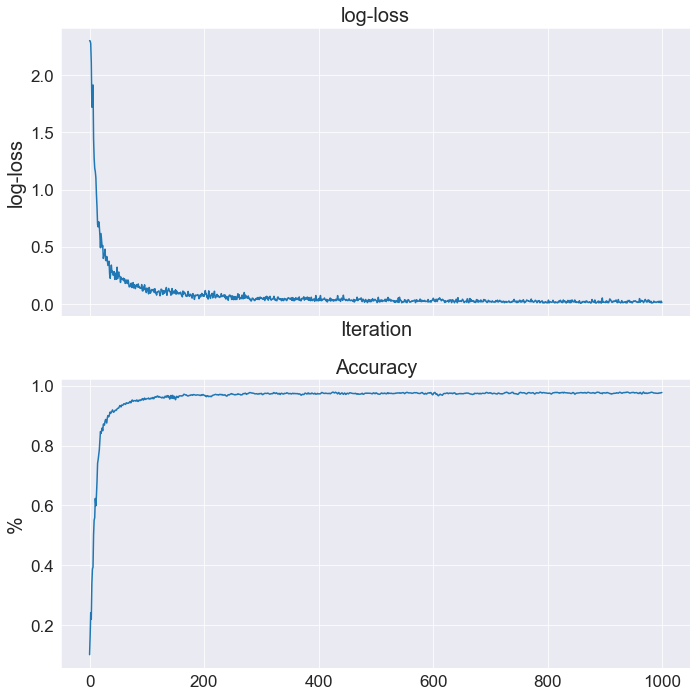

In [6]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(2, figsize=(10, 10), sharex=True)
ax[0].plot(loss_array)
ax[1].plot(accuracy_array)
ax[1].set_title("Accuracy", size=20)
ax[1].set_ylabel("%", size=20)
ax[0].set_title("log-loss", size=20)
ax[0].set_ylabel("log-loss", size=20)
ax[0].set_xlabel("Iteration", size=20)
plt.tight_layout()
print(f"Final accuracy: {accuracy_array[-1]:.3f}")

# OOD testing

In [7]:

@partial(jit, static_argnums=(1,3,6))
def run_adam_sg_simple(key, Niters, l_rate, batch_size, x_data, y_data, network_sizes, X_test, y_test):
    
    Ndata = x_data.shape[0]
    opt_init, opt_update, get_params = optimizers.adam(l_rate)
    
    @progress_bar_scan(Niters)
    def body(state, step):
        key, opt_state = state
        key, subkey = random.split(key)
        idx_batch = random.choice(key=subkey, a=jnp.arange(Ndata), shape=(batch_size,))
        
        _, loss_grad = value_and_grad(loss_NN)(get_params(opt_state), x_data[idx_batch,:], y_data[idx_batch,:])
        opt_state = opt_update(step, loss_grad, opt_state)
        return (key, opt_state), None
    
    key, subkey = random.split(key)
    M, D, K, L = network_sizes
    params_IC = init_params(subkey, M, D, K, L)
    state = (key, opt_init(params_IC))
    (_, opt_state), _ = lax.scan(body, state, jnp.arange(Niters))
    return get_params(opt_state)

run_ensemble_NN = vmap(run_adam_sg_simple, in_axes=(0, None,None,None,None,None,None,None,None))

In [8]:
Niters = 1000
M, L = 200, 4
Ndata, D = X_train.shape
K = y_train.shape[1]
network_sizes = (M, D, K, L)
l_rate = 1e-2
batch_size = 1000
key = random.PRNGKey(0)

Nensemble = 10
keys = random.split(key, Nensemble)

opt_param_ensemble = run_ensemble_NN(keys, Niters, l_rate, batch_size, X_train, y_train, network_sizes, X_test, y_test)
wait_until_computed(opt_param_ensemble)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
@jit
def entropy(logp_array):
    return jnp.sum(-logp_array*jnp.exp(logp_array))

batch_entropy = jit(vmap(entropy, in_axes=(0, )))

def get_entropy_ensemble(opt_param_ensemble, X_test):
    entropy_ensemble = []
    Nensemble = opt_param_ensemble[0][0].shape[0]
    for idx_M in range(Nensemble):
        opt_params_tmp = []

        for layer in opt_param_ensemble:
            a1, a2 = layer
            opt_params_tmp.append((a1[idx_M], a2[idx_M]))

        entropy_ensemble.append(batch_predict(opt_params_tmp, X_test))

    ensemble_predictive_prob = np.mean(entropy_ensemble, axis=0)
    return batch_entropy(ensemble_predictive_prob)

In [10]:
entropy_ensemble = get_entropy_ensemble(opt_param_ensemble, X_test_notMNIST)

In [11]:
entropy_single_NN = batch_entropy(batch_predict(opt_params, X_test_notMNIST))

<AxesSubplot:ylabel='Density'>

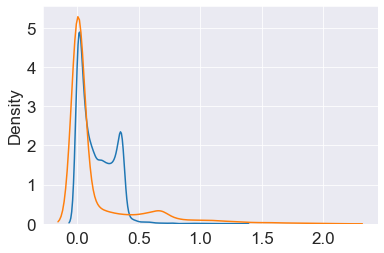

In [12]:
sns.kdeplot(entropy_ensemble, label=f"M={Nensemble}")
sns.kdeplot(entropy_single_NN, label=f"M=1")